In [1]:
%load_ext autoreload
import scanpy as sc

In [2]:
sc.set_figure_params(figsize=(5,5)) # no blurry figures allowed
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', frameon=True)
# sc.settings.set_figure_params(dpi=80, color_map='coolwarm')

In [3]:
%autoreload 2 

import sys
sys.path.append('./code/')
from init_global_vars import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
PATH_TO_ADATA = './adatas/transfer_adata.h5ad'
adata_transfer = sc.read_h5ad(PATH_TO_ADATA)

In [5]:
tcr_bcr_genes = ['Igha', 'Igkc', 'Jchain', 
                 'Trav5-1', 'Trav14d-3-dv8', 'Trav16n', 'Trav14n-3',
                 'Trav7-5', 'Trav13-1', 'Trav14-1', 'Trav4-3', 'Trav12-2', 'Trav14-2',
                 'Trav3-3', 'Trav4-4-dv10', 'Trav5-4', 'Trav6-7-dv9', 'Trav16',
                 'Trav14-3', 'Trav21-dv12', 'Ighd', 'Ighm', 
                 'Trbv1', 'Trbv2', 'Trbv3', 'Trbv12-1', 'Trbv13-1', 'Trbv12-2',
                 'Trbv13-2', 'Trbv13-3', 'Trbv15', 'Trbv16', 'Trbv19', 'Trbv20',
                 'Trbv26', 'Trbv31', 'Ptcra', 'Trdc', 'Iglc1', 'Trgc4',
                 'Trbv5', 'Trbv14', 'Trbv17', 'Trbv23', 'Trbv29', 'Trbv30', 'Trbc1',
                 'Trbc2', 'Trbv4', 'Trgc1', 'Trgc2'
            ]

print('Removing: ', adata_transfer.var.index[adata_transfer.var.index.isin(tcr_bcr_genes)].shape, ' TCR/BCR genes')
print('Removing: ', adata_transfer.var.index[adata_transfer.var.index.str.contains("-ps1")].shape, ' "-ps1" genes')
print('Removing: ', adata_transfer.var.index[adata_transfer.var.index.str.contains("Gm")].shape, ' "Gm" genes')

adata_transfer = adata_transfer[:, ~adata_transfer.var.index.isin(tcr_bcr_genes)]

Removing:  (33,)  TCR/BCR genes
Removing:  (1,)  "-ps1" genes
Removing:  (13,)  "Gm" genes


In [6]:
adata_transfer.layers['counts'] = np.asarray(adata_transfer.layers['counts'].todense())

In [7]:
adata_transfer.obs['counts_per_cell'] = np.ravel(adata_transfer.layers['counts'].sum(axis=1))
adata_transfer.var['counts'] = np.ravel(adata_transfer.layers['counts'].mean(axis=0))

adata_transfer = adata_transfer[adata_transfer.obs['pct_counts_mt'] < 2]
adata_transfer = adata_transfer[:, ~adata_transfer.var.index.str.contains("mt-")]

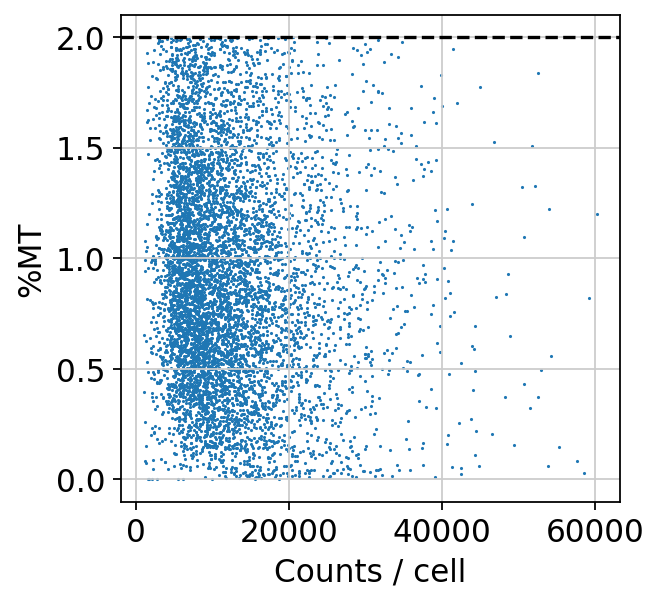

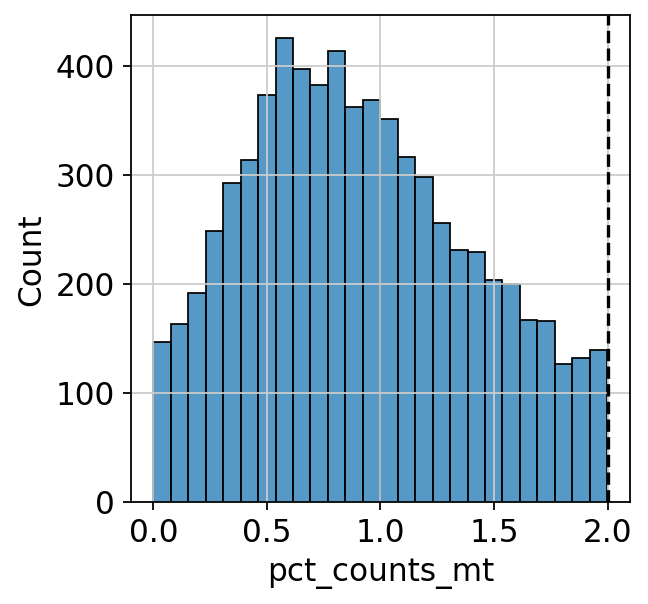

In [8]:
plt.scatter(adata_transfer.obs['counts_per_cell'], adata_transfer.obs['pct_counts_mt'], s = 2, linewidth=0)
plt.xlabel("Counts / cell")
plt.ylabel("%MT")
plt.axhline(2, color='black', linestyle='--')

plt.figure()
sns.histplot(adata_transfer.obs['pct_counts_mt'])
plt.axvline(2, color='black', linestyle='--')

In [9]:
from config import load_joris_rna
def score_genesets_on_adata(adata):
    dfdict, lfc_df, pval_df, _, _, _ = load_joris_rna()
    pval_df_all = pd.read_csv('./paper/tables/pval_df_all.csv', index_col = 0)
    lfc_df_all = pd.read_csv('./paper/tables/lfc_df_all.csv', index_col = 0)
    
    lfc_df_all = lfc_df_all.drop("Gt(ROSA)26Sor")
    pval_df_all = pval_df_all.drop("Gt(ROSA)26Sor")
        
    up_aTreg, up_rTreg = get_differential_sites(dfdict['activated_Treg_vs_resting_Treg'], 1e-4, .25)
    up_aTcon, down_aTcon = get_differential_sites(dfdict['activated_Tcon_vs_activated_Treg'], 1e-4, .55)
    up_rTcon, down_rTcon = get_differential_sites(dfdict['resting_Tcon_vs_resting_Treg'], 1e-4, .55)
    up_aKIKO, down_aKIKO = get_differential_sites(dfdict['activated_Foxp3_GFPKO_vs_activated_Treg_GFP_DTR_WT'], 1e-4, .25)
    up_rKIKO, down_rKIKO = get_differential_sites(dfdict['resting_Foxp3_GFPKO_vs_resting_Treg_GFP_DTR_WT'], 1e-4, .25)    

    up_r_bulk, down_r_bulk = get_differential_sites_separate_df(lfc_df_all, pval_df_all, 'wei_SpleenLN.TIR1.Resting_vs_SpleenLN.WT.Resting', .05, 0)
    up_a_bulk, down_a_bulk = get_differential_sites_separate_df(lfc_df_all, pval_df_all, 'wei_SpleenLN.TIR1.Activated_vs_SpleenLN.WT.Activated', .05, 0)
    up_t_bulk, down_t_bulk = get_differential_sites_separate_df(lfc_df_all, pval_df_all, 'wei_Thymus.TIR1.Developing_vs_Thymus.WT.Developing', .1, 0)
    up_rd7_tir1, down_rd7_tir1 = get_differential_sites_separate_df(lfc_df_all, pval_df_all, 'sc_rest_D7_tir1_vs_D7_wt', .1, 0)
    up_ad7_tir1, down_ad7_tir1 = get_differential_sites_separate_df(lfc_df_all, pval_df_all, 'sc_active_D7_tir1_vs_D7_wt', .1, 0)
    
    sc.tl.score_genes(adata, up_aTcon, score_name='up_aTcon')
    sc.tl.score_genes(adata, down_aTcon, score_name='down_aTcon')
    sc.tl.score_genes(adata, up_rTcon, score_name='up_rTcon')
    sc.tl.score_genes(adata, down_rTcon, score_name='down_rTcon')
    
    sc.tl.score_genes(adata, up_aTreg, score_name='up_aTreg')
    sc.tl.score_genes(adata, up_rTreg, score_name='up_rTreg')

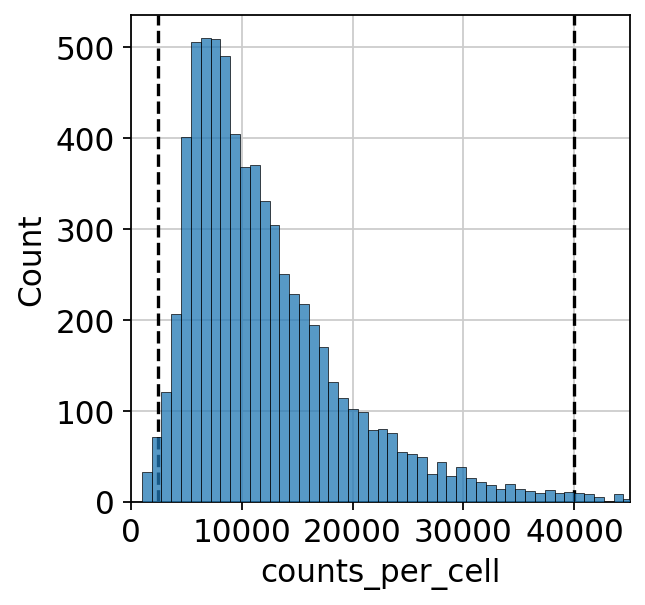

In [10]:
sns.histplot(adata_transfer.obs['counts_per_cell'], zorder=3)
plt.xlim([0, 45_000])
plt.axvline(2500, color='black', linestyle='--')
plt.axvline(40_000, color='black', linestyle='--')

adata_transfer = adata_transfer[(adata_transfer.obs['counts_per_cell'] > 2500) & (adata_transfer.obs['counts_per_cell'] <  40_000)]

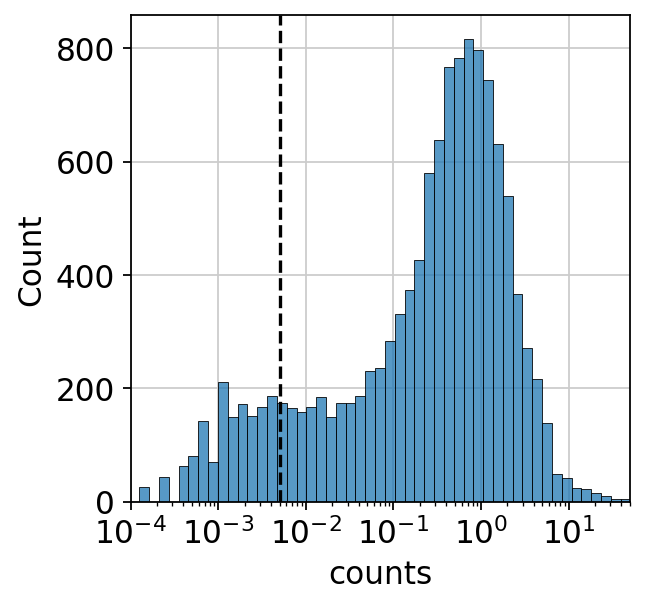

In [11]:
sns.histplot(adata_transfer.var['counts'], log_scale=True)
plt.xlim([1e-4, 5e1])
plt.axvline(.005, color='black', linestyle='--')

adata_transfer = adata_transfer[:, (adata_transfer.var['counts'] > .005)]

In [12]:
from update_process_adata import normalize_adata

In [13]:
normalize_adata(adata_transfer)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
    ... clipping at max_value 10


In [14]:
from aux_functions_scRNA import *

n_pcs = 100
sc.tl.pca(adata_transfer, n_comps=n_pcs, svd_solver='arpack')
# we like cosine similarity more so than Euclidean (better silhouettes once clustering)
sc.pp.neighbors(adata_transfer, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
sc.tl.leiden(adata_transfer, resolution = 1)
sc.tl.umap(adata_transfer)
# agg = aggregate_adata_by_obs_column(adata_transfer, key='leiden', layer='theta_10')
score_genesets_on_adata(adata_transfer)

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/g

    computed neighbors (0:00:44)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
computing score 'up_aTcon'
    finished: added
    'up_aTcon', score of gene set (adata.obs).
    1182 total control genes are used. (0:00:00)
computing score 'down_aTcon'
    finished: added
    'down_aTcon', score of gene set (adata.obs).
    1075 total control genes are used. (0:00:00)
computing score 'up_rTcon'
    finished: added
    'up_rTcon', score of gene set (adata.obs).
    1142 total control genes are used. (0:00:00)
computing score 'down_rTcon'
    finished: added
    'down_rTcon', score of gene set (adata.obs).
    1153 total control genes are used. (0:00:00)
computing score 'up_aTreg'
    finished: added
    'up_aTreg', score of gene set (adata.obs).
    1140 total control genes are used. (0:00:00)
computing score 'up_rTreg'
    finished: added
    'up_rTreg', score of gene set (adata.obs).
    1187 total control genes are used. (0:00:00)


In [15]:
sc.tl.leiden(adata_transfer, resolution = .5, key_added='leiden_res=0.5')
sc.tl.leiden(adata_transfer, resolution = .25, key_added='leiden_res=0.25')

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res=0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res=0.25', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_2331517/1797685010.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, _ in adata_transfer.obs.groupby('setting')['up_rTreg']:
/tmp/ipykernel_2331517/1797685010.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, _ in adata_transfer.obs.groupby('setting')['up_aTreg']:


Text(0.5, 0, 'Activation score')

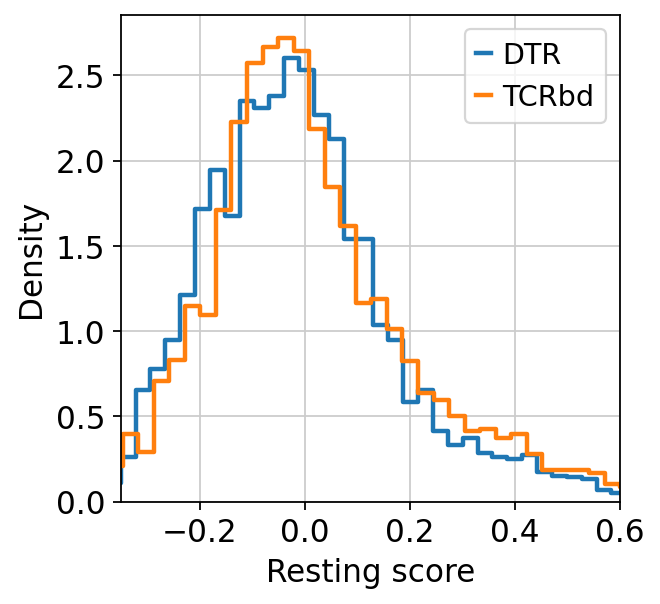

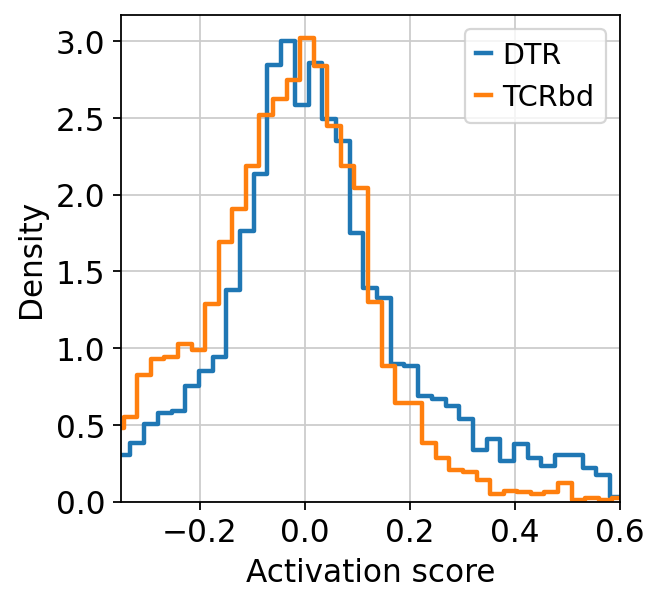

In [16]:
plt.figure()
for label, _ in adata_transfer.obs.groupby('setting')['up_rTreg']:
    sns.histplot(_, label=label, fill=False, element='step', linewidth = 2,
                stat='density')
plt.xlim([-.35, .6])
plt.legend()
plt.xlabel("Resting score")

plt.figure()
for label, _ in adata_transfer.obs.groupby('setting')['up_aTreg']:
    sns.histplot(_, label=label, fill=False, element='step', linewidth = 2,
                stat='density')
plt.xlim([-.35, .6])
plt.legend()
plt.xlabel("Activation score")

In [17]:
from aux_functions_scRNA import *
setting_specific_adatas = {}
for setting in adata_transfer.obs['setting'].unique():
    subadata = adata_transfer[adata_transfer.obs['setting'] == setting].copy()
    subadata.var['counts'] = np.ravel(subadata.layers['counts'].mean(axis=0))
    subadata = subadata[:, (subadata.var['counts'] > .005)]    
    normalize_adata(subadata)
    
    n_pcs = 100
    sc.tl.pca(subadata, n_comps=n_pcs, svd_solver='arpack')
    # we like cosine similarity more so than Euclidean (better silhouettes once clustering)
    sc.pp.neighbors(subadata, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
    sc.tl.leiden(subadata, resolution = 1)
    sc.tl.leiden(subadata, resolution = 0.25, key_added='leiden_res=0.25')
    sc.tl.leiden(subadata, resolution = 0.5, key_added='leiden_res=0.5')
    sc.tl.leiden(subadata, resolution = 2, key_added='leiden_res=2')

    sc.tl.umap(subadata)
    score_genesets_on_adata(subadata)
    setting_specific_adatas[setting] = subadata
    print("Done with", setting)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
    ... clipping at max_value 10
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:01)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res=0.25', the cluster labels (adata.obs, categoric

  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing score 'up_aTcon'
    finished: added
    'up_aTcon', score of gene set (adata.obs).
    1165 total control genes are used. (0:00:00)
computing score 'down_aTcon'
    finished: added
    'down_aTcon', score of gene set (adata.obs).
    1076 total control genes are used. (0:00:00)
computing score 'up_rTcon'
    finished: added
    'up_rTcon', score of gene set (adata.obs).
    1132 total control genes are used. (0:00:00)
computing score 'down_rTcon'
    finished: added
    'down_rTcon', score of gene set (adata.obs).
    1152 total control genes are used. (0:00:00)
computing score 'up_aTreg'
    finished: added
    'up_aTreg', score of gene set (adata.obs).
    1141 total control genes are used. (0:00:00)
computing score 'up_rTreg'
    finished: added
    'up_rTreg', score of gene set (adata.obs).
    1120 total control genes are used. (0:00:00)
Done with TCRbd


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
    ... clipping at max_value 10
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_res=0.25', the cluster labels (adata.obs, categoric

  0%|          | 0/500 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing score 'up_aTcon'
    finished: added
    'up_aTcon', score of gene set (adata.obs).
    1167 total control genes are used. (0:00:00)
computing score 'down_aTcon'
    finished: added
    'down_aTcon', score of gene set (adata.obs).
    1080 total control genes are used. (0:00:00)
computing score 'up_rTcon'
    finished: added
    'up_rTcon', score of gene set (adata.obs).
    1182 total control genes are used. (0:00:00)
computing score 'down_rTcon'
    finished: added
    'down_rTcon', score of gene set (adata.obs).
    1155 total control genes are used. (0:00:00)
computing score 'up_aTreg'
    finished: added
    'up_aTreg', score of gene set (adata.obs).
    1137 total control genes are used. (0:00:00)
computing score 'up_rTreg'
    finished: added
    'up_rTreg', score of gene set (adata.obs).
    1164 total control genes are used. (0:00:00)
Done with DTR


In [18]:
for setting in setting_specific_adatas:
    setting_specific_adatas[setting].write_h5ad(f'./adatas/{setting}.h5ad')

### Load to skip preprocessing

In [19]:
setting_specific_adatas = {}
for setting in ['TCRbd', 'DTR']:
    setting_specific_adatas[setting] = sc.read_h5ad(f'./adatas/{setting}.h5ad')

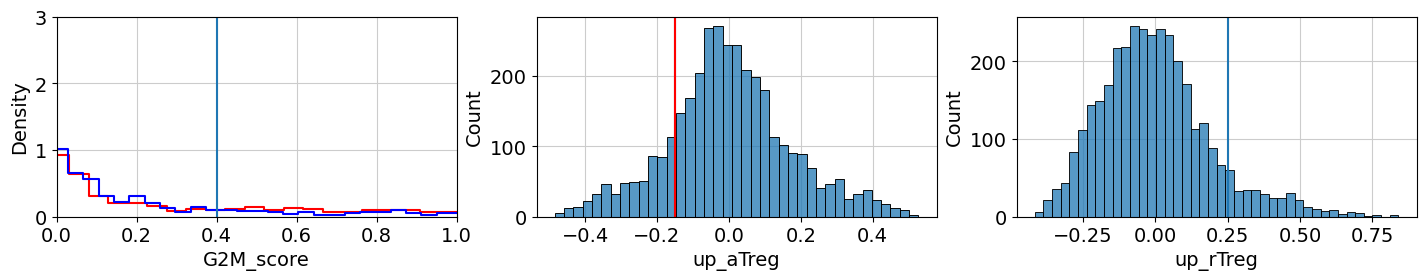

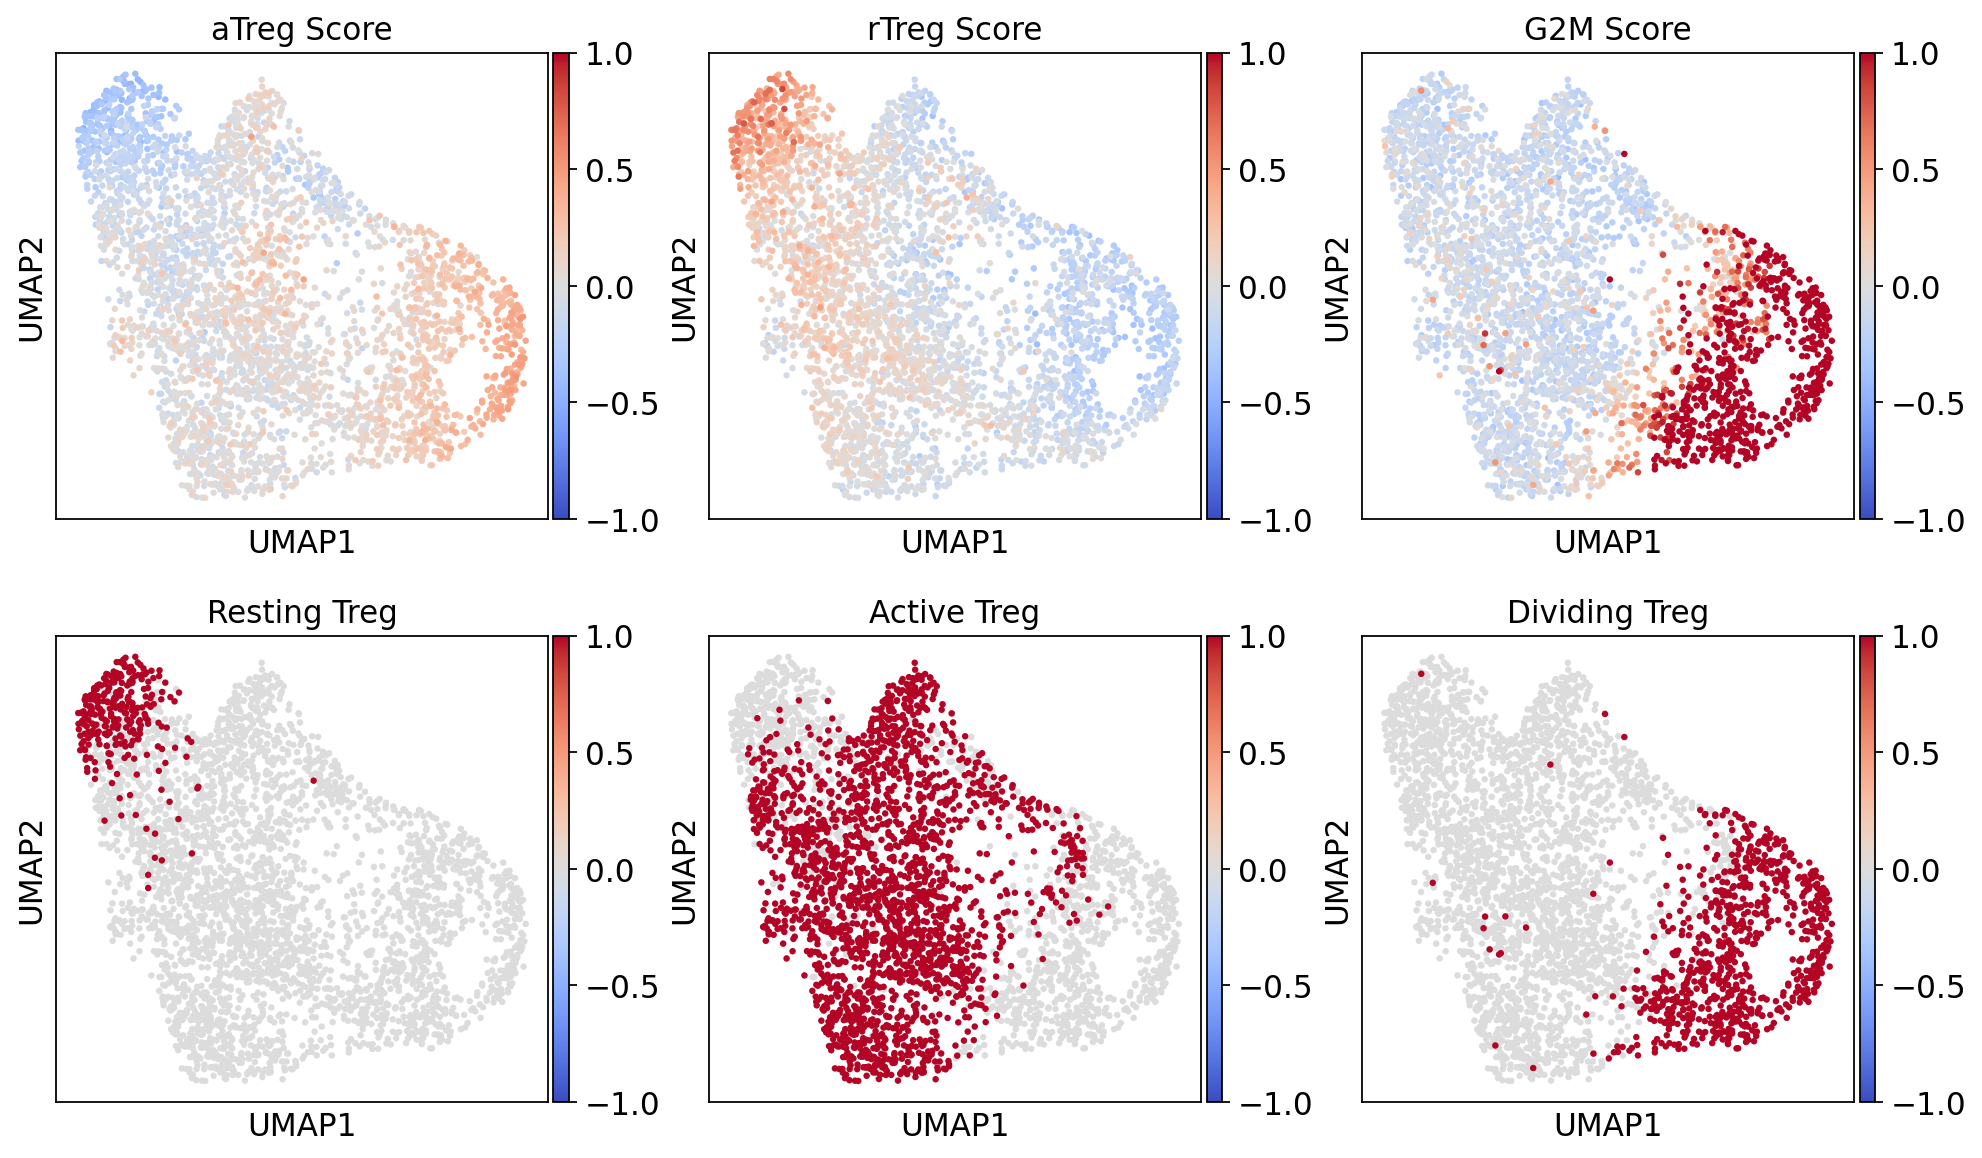

In [20]:
from update_active_resting import make_active_resting_cutoffs

from plotting_functions import init_subplots_exact
active_cutoff = -.15
not_active_cutoff = -.15
resting_cutoff = .25
dividing_cutoff = 0.4
plot = make_active_resting_cutoffs(dividing_cutoff, active_cutoff, resting_cutoff, not_active_cutoff, setting_specific_adatas['DTR'])

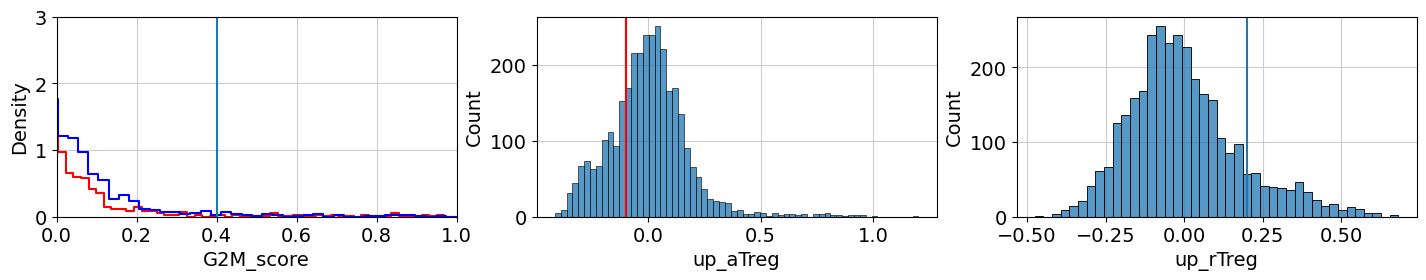

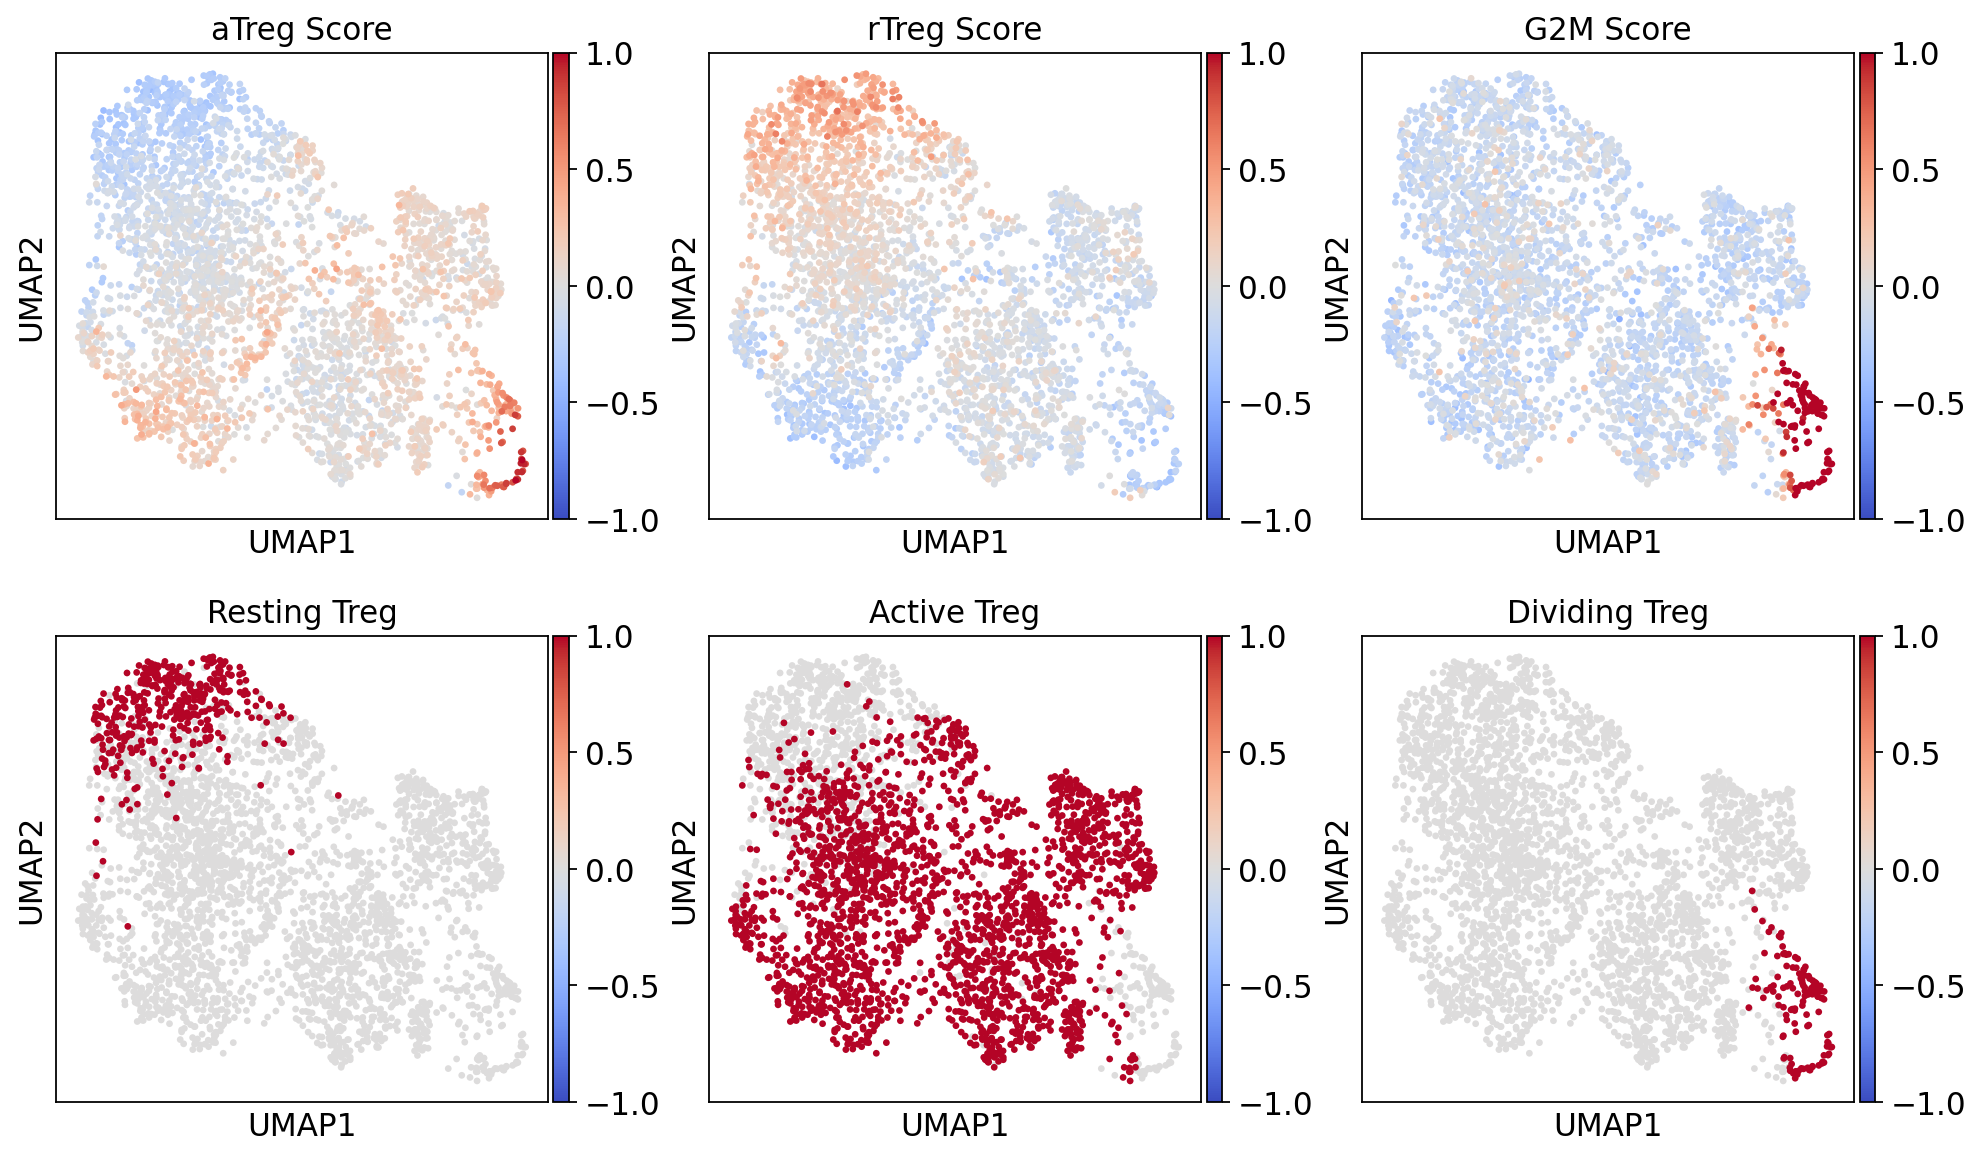

In [21]:
from update_active_resting import make_active_resting_cutoffs

from plotting_functions import init_subplots_exact
active_cutoff = -.1
resting_cutoff = .2
not_active_cutoff = -.1
dividing_cutoff = 0.4
plot = make_active_resting_cutoffs(dividing_cutoff, active_cutoff, resting_cutoff, not_active_cutoff, setting_specific_adatas['TCRbd'])

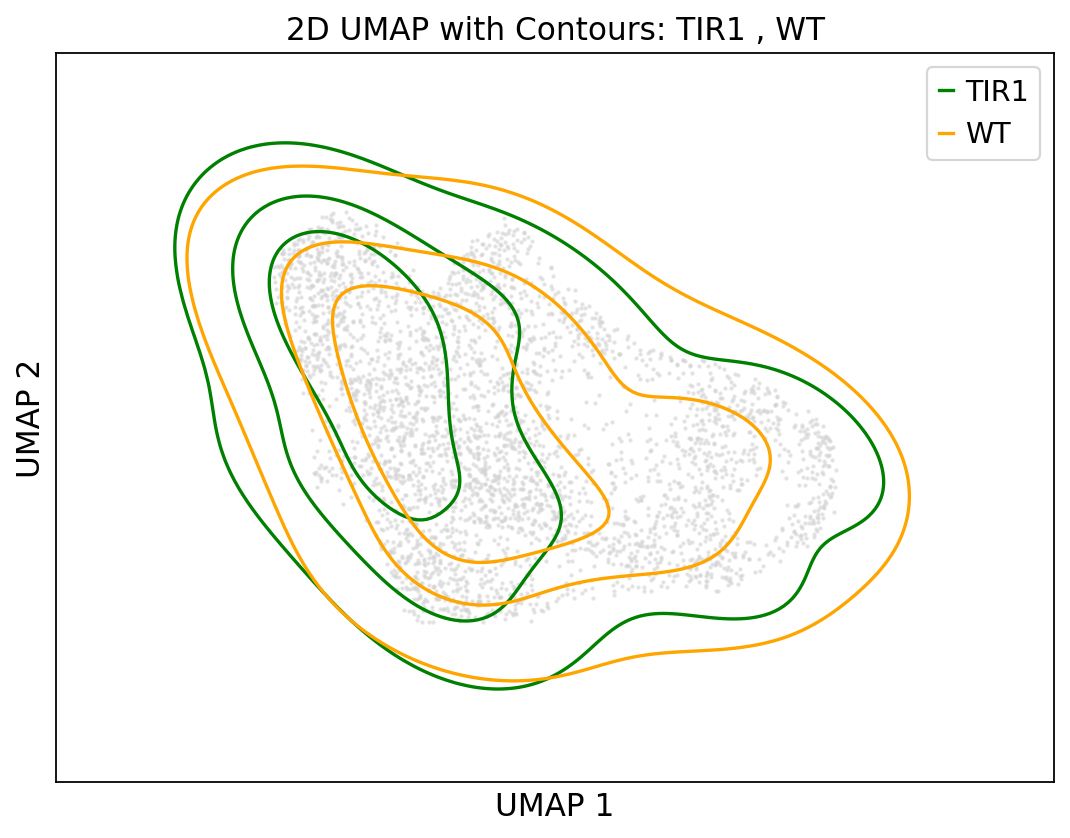

In [22]:
# KDE Density Plots
columns = [['TIR1', 'WT'],]
for col1, col2 in columns:
    umap_coords = setting_specific_adatas['DTR'].obsm['X_umap']
    
    # Create a mask for the two groups
    mask_tir1 = setting_specific_adatas['DTR'].obs['sort_label'] == col1
    mask_wt = setting_specific_adatas['DTR'].obs['sort_label'] == col2
    
    scatter_idx = mask_tir1 | mask_wt
    
    # Get UMAP coordinates for each group
    umap_tir1 = umap_coords[mask_tir1]
    umap_wt = umap_coords[mask_wt]
    
    # Plot the UMAP with contours
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title(f'2D UMAP with Contours: {col1} , {col2}')
    
    # Scatter plot for all points in grey
    plt.scatter(umap_coords[scatter_idx, 0], umap_coords[scatter_idx, 1], c='lightgrey', alpha=0.5, s=1)
    
    # Contour plots
    sns.kdeplot(x = umap_tir1[:, 0], y = umap_tir1[:, 1], levels = 4, linewidths = 1.5, color = 'green', label = col1, bw_adjust = 1.2)
    sns.kdeplot(x = umap_wt[:, 0], y = umap_wt[:, 1], levels = 4, linewidths = 1.5, color = 'orange', label = col2, bw_adjust = 2)
    plt.plot([], [], label=col1, color='green',)
    plt.plot([], [], label=col2, color='orange',)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    fig.savefig(f'./FINAL_PLOTS/transfer_scrna/contour_plot_DTR.pdf', bbox_inches='tight')

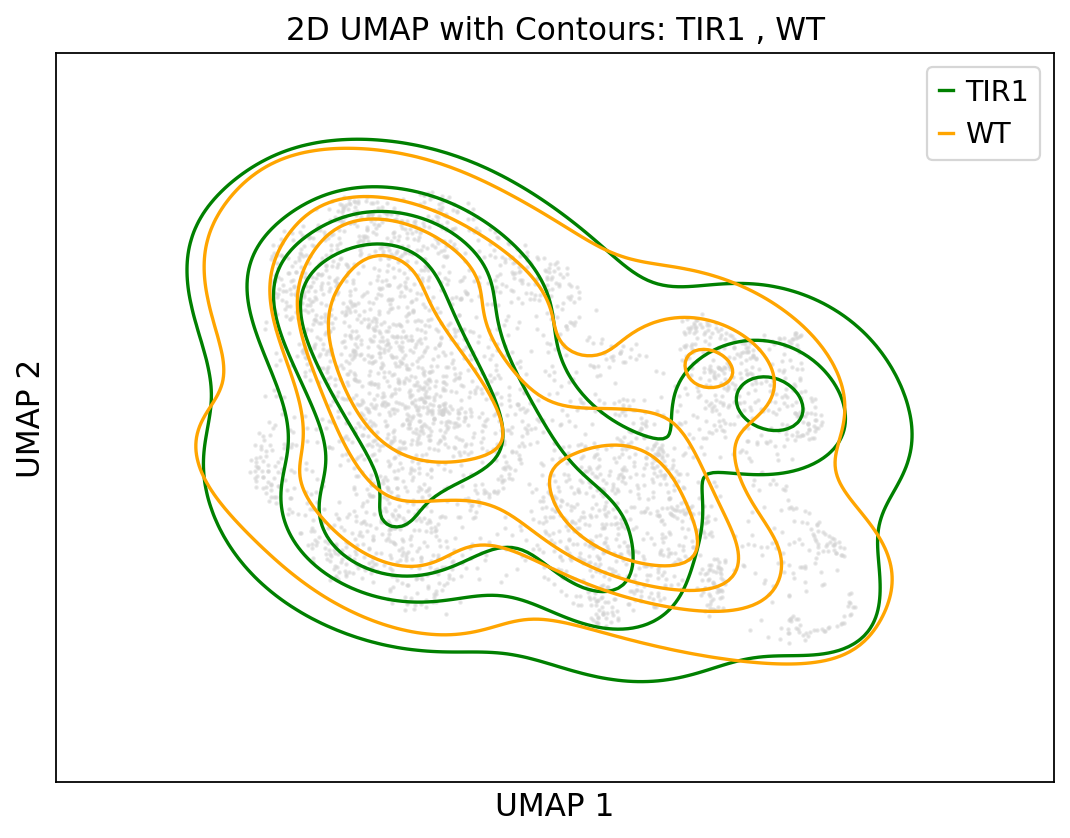

In [23]:
# Extract UMAP coordinates
columns = [['TIR1', 'WT']]
for col1, col2 in columns:
    umap_coords = setting_specific_adatas['TCRbd'].obsm['X_umap']
    
    # Create a mask for the two groups
    mask_tir1 = setting_specific_adatas['TCRbd'].obs['sort_label'] == col1
    mask_wt = setting_specific_adatas['TCRbd'].obs['sort_label'] == col2
    
    scatter_idx = mask_tir1 | mask_wt
    
    # Get UMAP coordinates for each group
    umap_tir1 = umap_coords[mask_tir1]
    umap_wt = umap_coords[mask_wt]
    
    # Plot the UMAP with contours
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title(f'2D UMAP with Contours: {col1} , {col2}')
    
    # Scatter plot for all points in grey
    plt.scatter(umap_coords[scatter_idx, 0], umap_coords[scatter_idx, 1], c='lightgrey', alpha=0.5, s=1)
    
    # Contour plots
    sns.kdeplot(x = umap_tir1[:, 0], y = umap_tir1[:, 1], levels = 5, linewidths = 1.5, color = 'green', label = col1, bw_adjust = 1.4)
    sns.kdeplot(x = umap_wt[:, 0], y = umap_wt[:, 1], levels = 5, linewidths = 1.5, color = 'orange', label = col2, bw_adjust = 1.4)
    plt.plot([], [], label=col1, color='green',)
    plt.plot([], [], label=col2, color='orange',)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    fig.savefig(f'./FINAL_PLOTS/transfer_scrna/contour_plot_TCRbd.pdf', bbox_inches='tight')

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

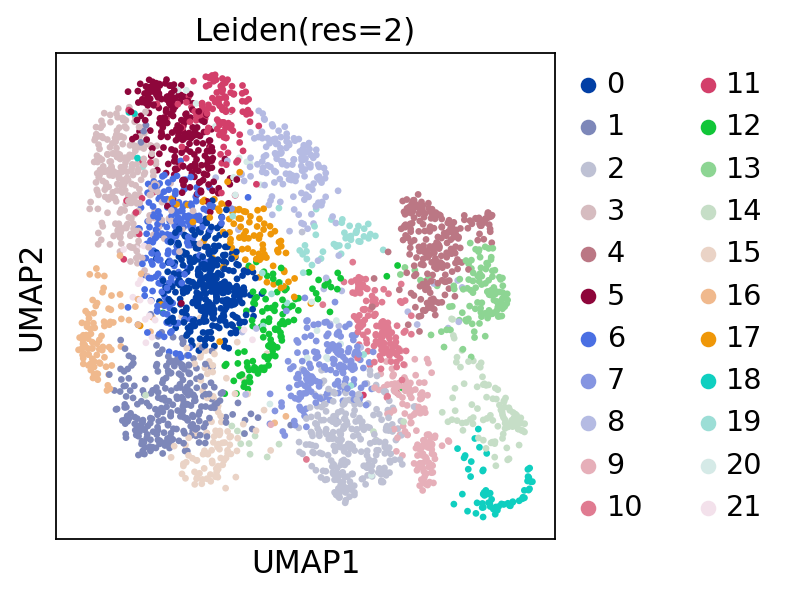

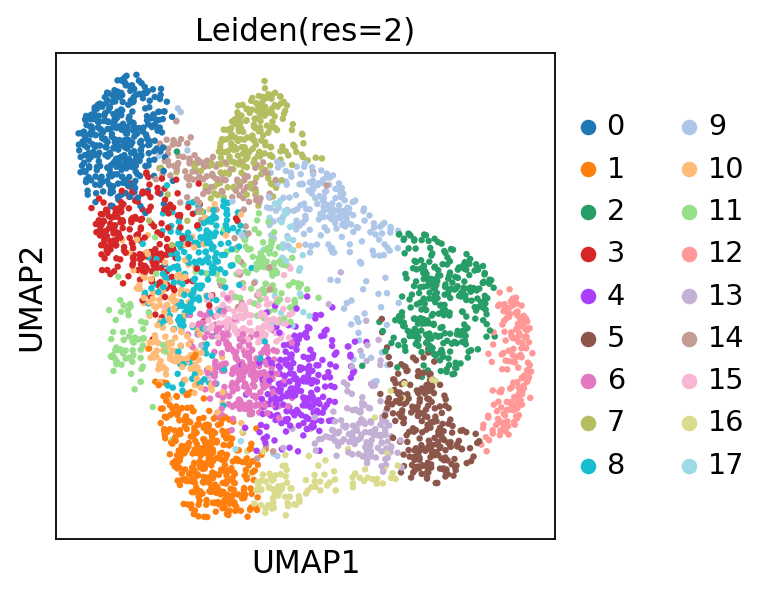

In [24]:
for tissue in setting_specific_adatas:
    fig = sc.pl.umap(setting_specific_adatas[tissue], color=['leiden_res=2'],
               title=['Leiden(res=2)'],
                     return_fig=True, wspace = .6
              )
    fig.savefig(f'./FINAL_PLOTS/transfer_scrna/leiden_plots_{tissue}.pdf', bbox_inches='tight')

Using paired t-test


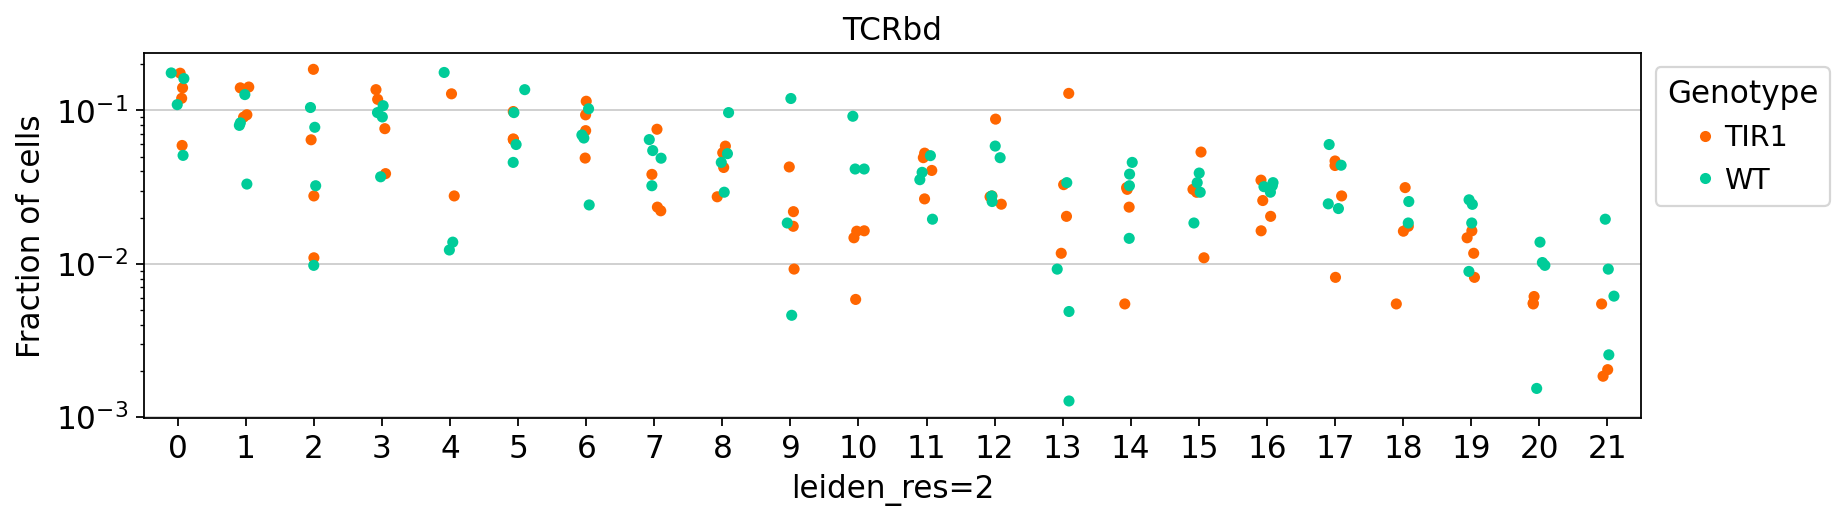

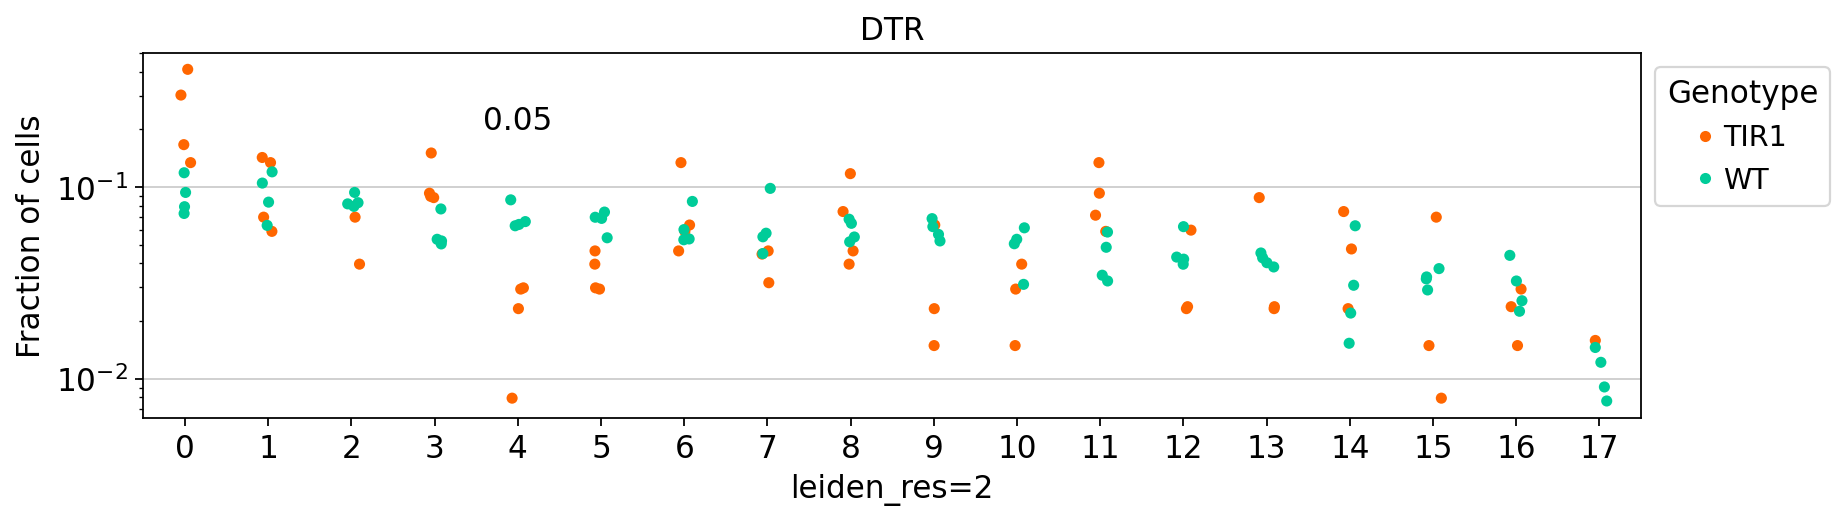

In [25]:
from update_scrna_plots import leiden_cell_abundance_stripplots_matched_t_test

figs = leiden_cell_abundance_stripplots_matched_t_test(setting_specific_adatas, leiden_col = 'leiden_res=2')
figs[0].savefig('./FINAL_PLOTS/transfer_scrna/frequencies_tcrbd_leiden_res=2.pdf', bbox_inches='tight')
figs[1].savefig('./FINAL_PLOTS/transfer_scrna/frequencies_DTR_leiden_res=2.pdf', bbox_inches='tight')

In [26]:
matched_deseq_l2fc_df = pd.read_csv('./deseq2/transfer.lfc.tsv', sep='\t', index_col = 0)
matched_deseq_padj_df = pd.read_csv('./deseq2/transfer.padj.tsv', sep='\t', index_col = 0)

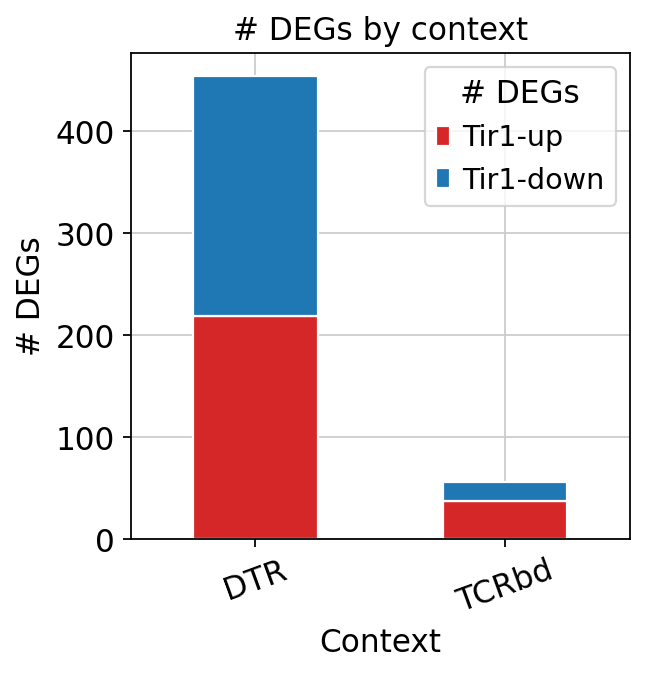

In [27]:
from update_scrna_plots import n_deg_plot

fig = n_deg_plot(matched_deseq_padj_df, matched_deseq_l2fc_df)
plt.xticks(rotation=20)
fig.savefig('./FINAL_PLOTS/transfer_scrna/n_degs_by_experiment.pdf', bbox_inches='tight')

/Genomics/pritykinlab/gabe/jupys/tregs/rudensky_scrna/prelim-analysis/../../code/plotting_functions.py:1036: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  c = ax.scatter(X, Y, **kwargs)


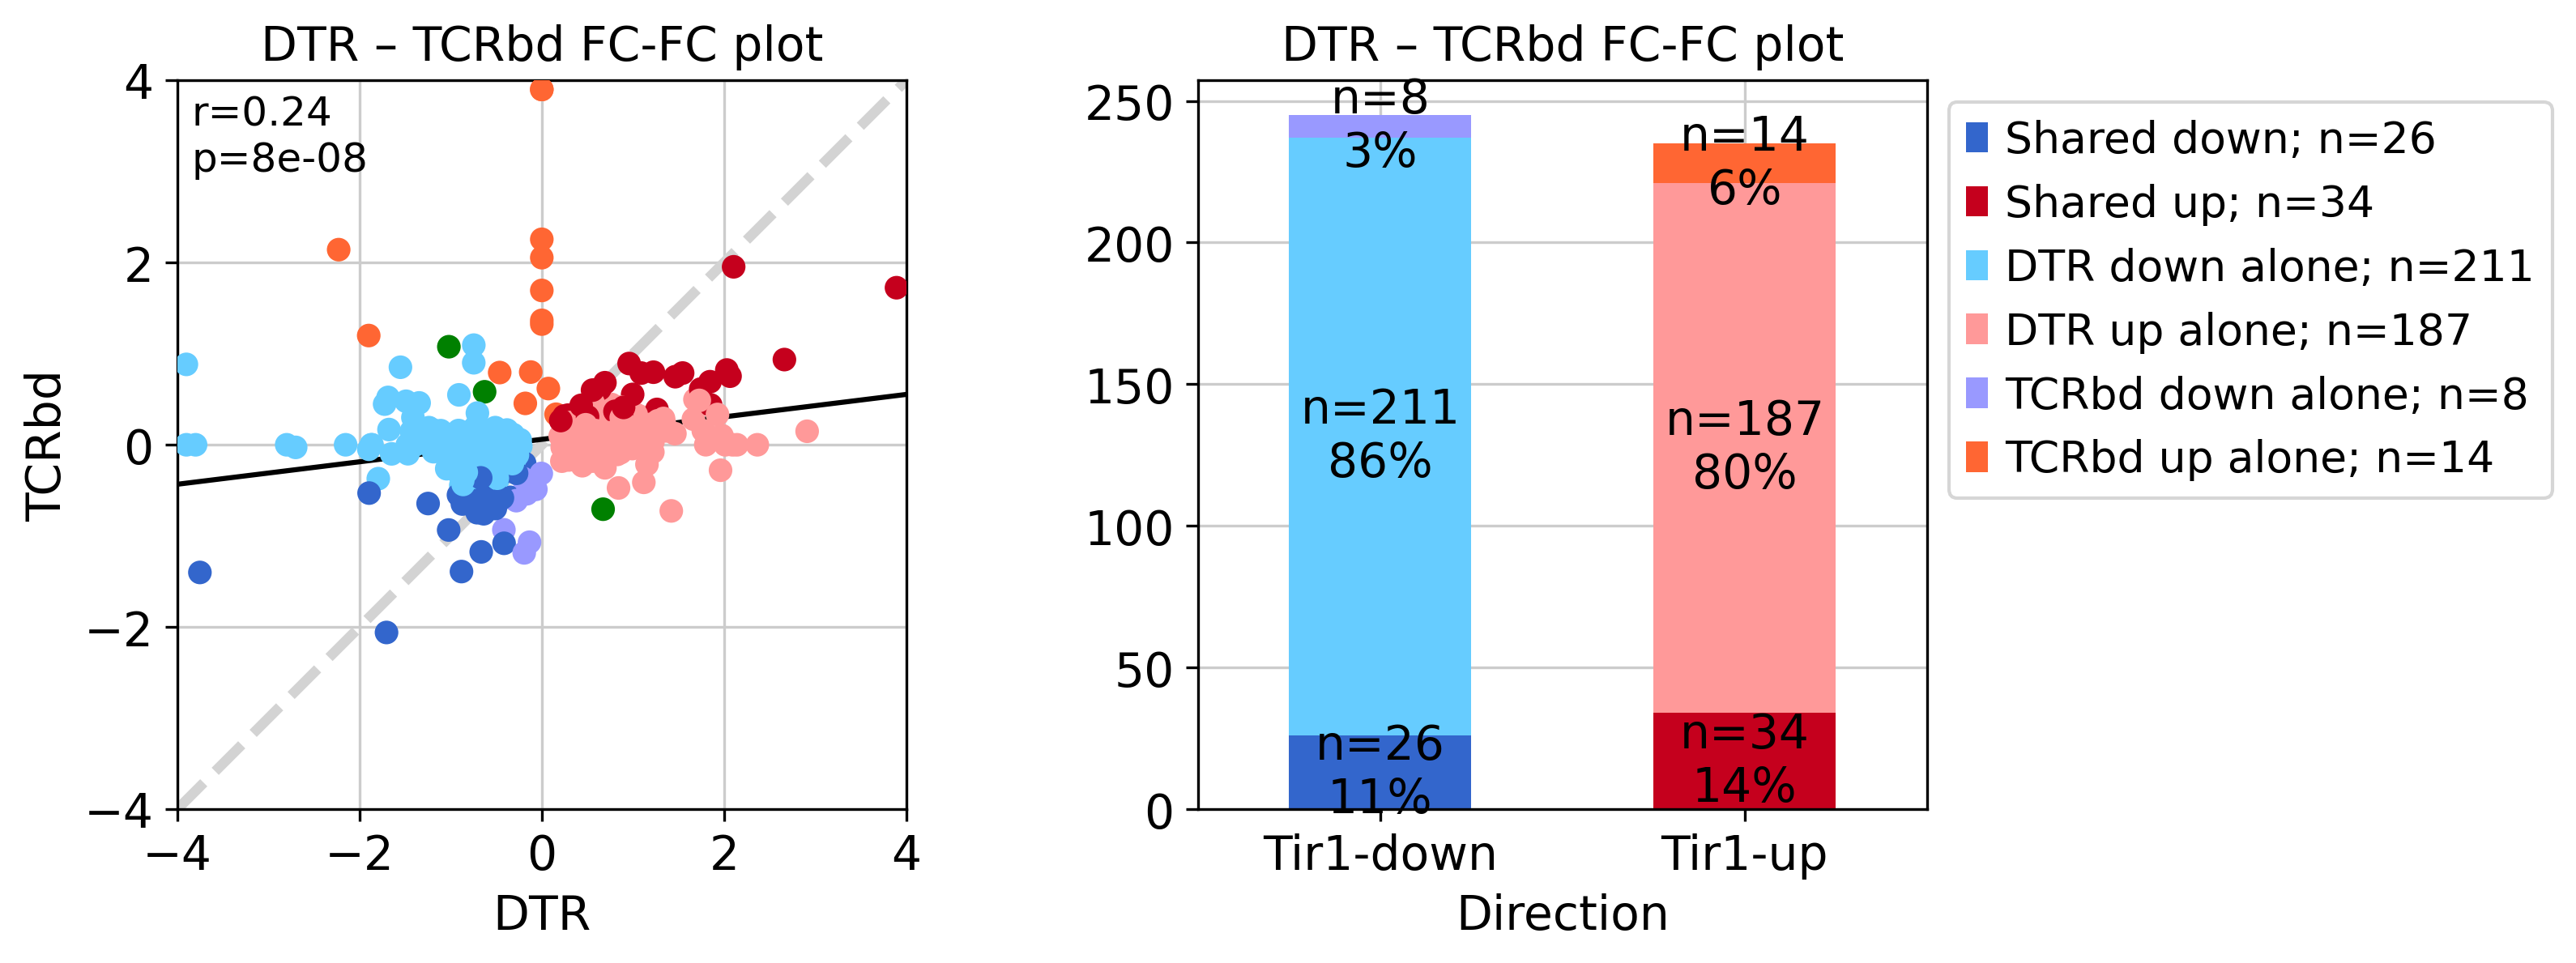

In [28]:
from plotting_functions import *
from update_fc_fc_plots import compute_deg_annotations_signed

deg_fractions = pd.DataFrame()
all_annotations = []
for setting1, setting2 in [['DTR', 'TCRbd']]:
    name1, name2 = setting1, setting2
    annotations2 = compute_deg_annotations_signed(
        matched_deseq_l2fc_df,
        matched_deseq_padj_df,
        tissue1 = setting1,
        tissue2 = setting2,
        lfc_agreement_cutoff = .5,
    ).dropna()
    
    degs = annotations2.index
    x, y = matched_deseq_l2fc_df[setting1][degs].copy(), matched_deseq_l2fc_df[setting2][degs].copy()
    x = x.fillna(0).clip(-3.9, 3.9)
    y = y.fillna(0).clip(-3.9, 3.9)
    og_annotations = annotations2['Label'].copy()
    c = og_annotations.copy()
    c[c=='Shared up'] = '#C5001D'
    c[c==f'Shared down'] = '#3366CC'
    c[c==f'{setting1} up alone'] = '#FF9999'
    c[c==f'{setting1} down alone'] = '#66CCFF'
    c[c==f'{setting2} up alone'] = '#FF6633'
    c[c==f'{setting2} down alone'] = '#9999FF'
    c[c=='Opposite'] = 'green'
    fig, axs = init_subplots_exact(2, 1, fgsz=(3, 3), xspace = 1.4, dpi = 150)
    plt.sca(axs[0])
    scatter_with_pearson(x, y, ax=axs[0], fontsize=12, cmap='coolwarm', c = c, zorder=3, vmin=-1, vmax=1,)
    for u in np.unique(c):
        n = np.sum(c==u)
        # plt.scatter([0], [0], c=[u], label=f'{color_to_labels[u]}; n={n}', cmap='coolwarm', vmin = -1, vmax = 1)
    # plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel(name1)
    plt.ylabel(name2)
    z = np.linspace(-4, 4)
    m, b = scipy.stats.linregress(x, y)[:2]
    plt.plot(z, z*m+b, color='black')
    plt.plot(z, z, color='lightgray', linestyle = '--', 
             linewidth = 3,
             zorder = 1)

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    
    plt.sca(axs[1])
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    
    d_up = og_annotations[og_annotations.str.contains('up')].value_counts().reset_index()
    d_up['count'] = d_up['count']# / d_up['count'].sum()
    d_down = og_annotations[og_annotations.str.contains('down')].value_counts().reset_index()
    d_down['count'] = d_down['count']# / d_down['count'].sum()
    data = pd.concat([d_up, d_down])
    
    data['Direction'] = data['Label'].str.contains('up')
    data.loc[data['Direction']==True, 'Direction'] = 'Tir1-up'
    data.loc[data['Direction']==False, 'Direction'] = 'Tir1-down'
    
    label2color = pd.concat([c, og_annotations],axis=1)
    label2color.columns = ['Color', 'Label']
               
    label2color_dict = dict(zip(label2color['Label'], label2color['Color']))
    
    order = [
        'Shared down', 'Shared up',
        f'{setting1} down alone', f'{setting1} up alone', 
        f'{setting2} down alone', f'{setting2} up alone']
    
    # Pivot and plot
    pivot_df = data.pivot(index='Direction', columns='Label', values='count')[order]
    ax = pivot_df.plot.bar(
        stacked=True,
        color=[label2color_dict.get(x) for x in order],
        legend=False,
        ax=plt.gca()
    )
    
    # Clean up x-axis
    plt.xticks(rotation=0)
    
    # Create custom legend
    handles = [
        Patch(facecolor=label2color_dict[label], label=f"{label}; n={data.set_index('Label').loc[label, 'count']}")
        for label in order
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1, 1))
    
    for container in ax.containers:
        labels = []
        for bar in container:
            height = bar.get_height()
            if 'up' in container.get_label():
                total_height = pivot_df.T.sum()['Tir1-up']
            else:
                total_height = pivot_df.T.sum()['Tir1-down']
            if height > 0:
                labels.append(f'n={height:.0f}\n{height/total_height*100:.0f}%')
            else:
                labels.append('')
        ax.bar_label(container, labels=labels, label_type='center')
    
    for ax in axs:
        ax.set_title(f'{name1} – {name2} FC-FC plot')
    all_annotations.append(pd.Series(annotations2['Label'], name = f'{name1}_{name2}'))

    fig.savefig(f'./FINAL_PLOTS/transfer_scrna/fc_fc_{setting1}_{setting2}.pdf', bbox_inches='tight')
all_annotations = pd.DataFrame(all_annotations).T